
# Regression models for Sales Forecasting

- Prepared By Muhammad Ejaz

In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import joblib
import xgboost as xgb

In [2]:
# Load file from local directory
df=pd.read_excel(r'E:\DATA Science\portfolio project\Nexus\BJ_Bakery_dataset .xlsx')

print(df.head())


   S.No Transaction Date         Full Name Buyer Location Buyer Date of Birth  \
0     1       2024-02-20      Allen Santos       San Jose          1954-10-23   
1     2       2024-03-15       Brenda Shaw       San Jose          1980-05-05   
2     3       2024-01-13  Robert Hernandez    San Antonio          1966-05-10   
3     4       2024-05-09   Alexander Smith       San Jose          1945-09-16   
4     5       2024-05-20    Mary Rodriguez   Philadelphia          1953-11-19   

  Payment Method  Quantity Purchased Product Code  Cost  UnitPrice  Revenue  \
0    Credit Card                 129        Pro04    10         14     1806   
1           Cash                 370        Pro09    10         45    16650   
2    Credit Card                 284        Pro02    18         22     6248   
3     Debit Card                  90        Pro05    14         28     2520   
4           Cash                 475        Pro04    10         14     6650   

   Profit  profit Margin Sales Represe

In [3]:
# checking missing values and data types

#remove S.No column 
df.drop(columns=['S.No'], inplace=True)

print('\nMissing values per column:')

print(df.isnull().sum())

print('\nData types:')
print(df.dtypes)


Missing values per column:
Transaction Date        0
Full Name               0
Buyer Location          0
Buyer Date of Birth     0
Payment Method          0
Quantity Purchased      0
Product Code            0
Cost                    0
UnitPrice               0
Revenue                 0
Profit                  0
profit Margin           0
Sales Representative    0
Gender                  0
dtype: int64

Data types:
Transaction Date        datetime64[ns]
Full Name                       object
Buyer Location                  object
Buyer Date of Birth     datetime64[ns]
Payment Method                  object
Quantity Purchased               int64
Product Code                    object
Cost                             int64
UnitPrice                        int64
Revenue                          int64
Profit                           int64
profit Margin                  float64
Sales Representative            object
Gender                          object
dtype: object


## Feature engineering

Create time-based features such as `date`, `month`, `day_of_week`, `is_weekend`, `promo_flag` 


In [4]:
# Feature engineering example
try:
    # Try to find a date column
    date_col = None
    for c in df.columns:
        if 'date' in c.lower() or 'day' in c.lower() or 'sale_date' in c.lower():
            date_col = c
            break
    if date_col is None:
        # try to detect dtype
        for c in df.columns:
            if np.issubdtype(df[c].dtype, np.datetime64):
                date_col = c
                break
    if date_col is None:
        print('No obvious date column found. You must set `date_col` manually to your date column name.')
    else:
        print('Using date column:', date_col)
        df['date'] = pd.to_datetime(df[date_col])
        df = df.sort_values('date').reset_index(drop=True)

        # Basic time features
        df['month'] = df['date'].dt.month
        df['day_of_week'] = df['date'].dt.weekday
        df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

        #  promo flag if any column contains 'promo' or 'promotion'
        promo_cols = [c for c in df.columns if 'promo' in c.lower() or 'promotion' in c.lower()]
        if promo_cols:
            df['promo_flag'] = df[promo_cols].any(axis=1).astype(int)
        else:
            df['promo_flag'] = 0

        display(df[['date','month','day_of_week','is_weekend','promo_flag']].head())
except Exception as e:
    print('Error during feature engineering:', e)

Using date column: Transaction Date


,date,month,day_of_week,is_weekend,promo_flag
0,2024-01-01,1,0,0,0
1,2024-01-01,1,0,0,0
2,2024-01-01,1,0,0,0
3,2024-01-01,1,0,0,0
4,2024-01-01,1,0,0,0


## Missing values & outlier handling

Approach suggestions:
- Fill missing numeric values 
- Clip or cap extreme outliers 

In [5]:
# Imputation & Outlier Handling for 'Revenue'

try:
    target_col = 'Revenue'
    print('Target column set to:', target_col)

    # Impute numeric columns by interpolation or median
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        if df[c].isna().sum() > 0:
            if 'date' in df.columns and np.issubdtype(df['date'].dtype, np.datetime64):
                df[c] = df[c].interpolate(method='time')
            else:
                df[c] = df[c].fillna(df[c].median())
    print(" Missing values imputed (time-based or median).")

    # Outlier capping for Revenue using IQR method
    q1 = df[target_col].quantile(0.25)
    q3 = df[target_col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df['target_clipped'] = df[target_col].clip(lower, upper)
    print("Applied IQR-based clipping to 'Revenue' → stored in 'target_clipped'.")

    # Quick summary stats
    display(df[[target_col, 'target_clipped']].describe())

except Exception as e:
    print('Error during imputation or clipping:', e)


Target column set to: Revenue
 Missing values imputed (time-based or median).
Applied IQR-based clipping to 'Revenue' → stored in 'target_clipped'.


,Revenue,target_clipped
count,12000.000000,12000.000000
mean,5130.656917,5028.764917
std,4665.189899,4371.505913
min,50.000000,50.000000
25%,1680.000000,1680.000000
50%,3498.000000,3498.000000
75%,7448.000000,7448.000000
max,22500.000000,16100.000000


## Train/test split & time-based 



In [6]:
# Train/test split (Target = 'Revenue')

try:
    target_col = 'Revenue'  # explicitly set the target
    print('Using target column:', target_col)

    # Handle target clipping
    if 'target_clipped' in df.columns:
        y = df['target_clipped'].values
        print("Using 'target_clipped' as target.")
    else:
        y = df[target_col].values
        print("Using raw 'Revenue' as target.")

    # Prepare feature set: drop target + irrelevant columns
    drop_cols = [target_col, 'target_clipped', 'date', 'index', 'Unnamed: 0']
    drop_cols = [c for c in drop_cols if c in df.columns]  # keep only existing columns

    X = df.drop(columns=drop_cols, errors='ignore')
    X = X.select_dtypes(include=[np.number]).copy()  # numeric features only

    # Holdout: last 10% for test
    cutoff = int(len(df) * 0.9)
    X_train, X_test = X.iloc[:cutoff], X.iloc[cutoff:]
    y_train, y_test = y[:cutoff], y[cutoff:]

    print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

    # Time-based cross-validation setup
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=10)
    print(" Prepared TimeSeriesSplit with 10 splits for time based.")

except Exception as e:
    print("Error preparing train/test split:", e)


Using target column: Revenue
Using 'target_clipped' as target.
Train size: (10800, 9), Test size: (1200, 9)
 Prepared TimeSeriesSplit with 10 splits for time based.


## Modeling
 LinearRegression , RandomForestRegressor, and LightGBM / XGBoost.

In [7]:


# Modeling containers
results = []
models = {}

# helper: root mean squared error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results.append({
    'model': 'LinearRegression',
    'RMSE': rmse(y_test, y_pred_lr),
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'R2': r2_score(y_test, y_pred_lr)
})
models['LinearRegression'] = lr
print('LinearRegression done')

# 2. RandomForest
rf = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append({
    'model': 'RandomForest',
    'RMSE': rmse(y_test, y_pred_rf),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
})
models['RandomForest'] = rf
print('RandomForest done')

# 3. XGBoost
xg = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, verbosity=0, random_state=42)
xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)
results.append({
    'model': 'XGBoost',
    'RMSE': rmse(y_test, y_pred_xg),
    'MAE': mean_absolute_error(y_test, y_pred_xg),
    'R2': r2_score(y_test, y_pred_xg)
})
models['XGBoost'] = xg
print('XGBoost done')

# Show evaluation table
res_df = pd.DataFrame(results).set_index('model')
display(res_df)

LinearRegression done
RandomForest done
XGBoost done


,RMSE,MAE,R2
model,,,
LinearRegression,962.295674,713.934799,0.951251
RandomForest,77.029111,52.423774,0.999688
XGBoost,24.315106,16.786304,0.999969


## Explainability and Diagnostics

- Feature importance 
- plots and autocorrelation checks


              feature  importance
3              Profit    0.680307
4       profit Margin    0.260790
0  Quantity Purchased    0.040667
1                Cost    0.018082
2           UnitPrice    0.000149
6         day_of_week    0.000004
5               month    0.000002
7          is_weekend    0.000000
8          promo_flag    0.000000


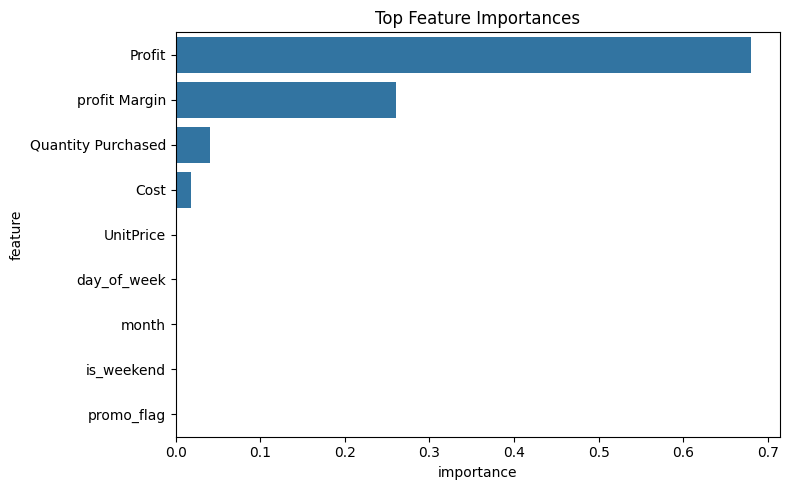

In [8]:
# Check feature importances (robust: handle missing `loaded_model`)
# Prefer `loaded_model` if present; else try to pick the best model from `models`; else attempt to load from disk.
model = None

# 1) use already-loaded variable
if 'loaded_model' in globals():
    model = loaded_model

# 2) else, pick best from trained `models` dict (using res_df if available)
elif 'models' in globals() and isinstance(models, dict) and len(models) > 0:
    try:
        best_name = None
        if 'res_df' in globals():
            best_name = res_df['RMSE'].idxmin()
        if best_name and best_name in models:
            model = models[best_name]
        else:
            # fallback to first model in dict
            model = list(models.values())[0]
    except Exception:
        model = list(models.values())[0]

# 3) else, try to load from disk
else:
    import os
    if os.path.exists('best_sales_model.joblib'):
        try:
            model = joblib.load('best_sales_model.joblib')
            loaded_model = model  # set for later cells
        except Exception as e:
            print("Failed to load 'best_sales_model.joblib':", e)

if model is None:
    raise NameError("No model available. Ensure `loaded_model` or `models` exists or 'best_sales_model.joblib' is present.")

# determine feature columns
if 'X_train' in globals() and hasattr(X_train, 'columns'):
    feature_cols = X_train.columns
elif 'X' in globals() and hasattr(X, 'columns'):
    feature_cols = X.columns
else:
    feature_cols = None

# Plot feature importances if available
if hasattr(model, 'feature_importances_') and feature_cols is not None:
    imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(imp.head(10))

    # Plot
    plt.figure(figsize=(8,5))
    sns.barplot(data=imp.head(20), x='importance', y='feature')
    plt.title('Top Feature Importances')
    plt.tight_layout()
    plt.show()
else:
    print("This model type does not have feature_importances_ or feature names are unavailable.")

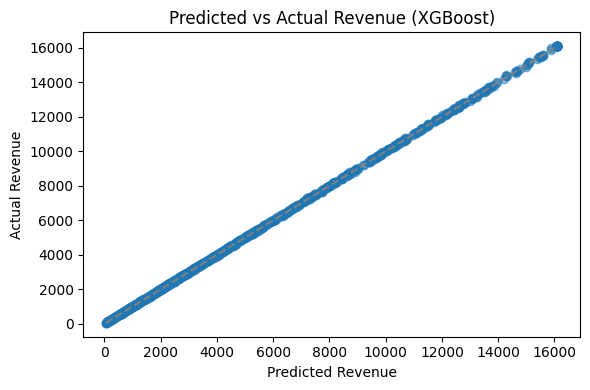

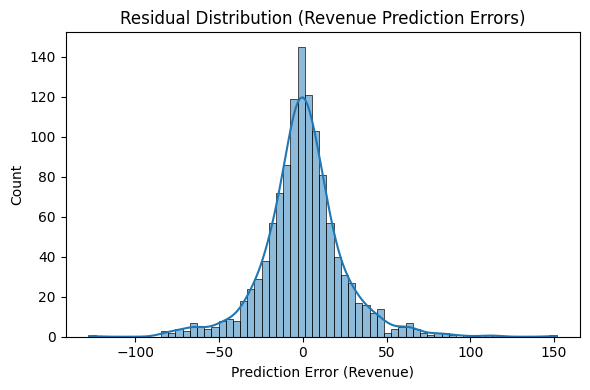

In [9]:
# Residuals for the best model
best = res_df['RMSE'].idxmin()
y_pred_best = models.get(best, None)
if y_pred_best is not None:
    y_pred_best = y_pred_best.predict(X_test)
else:
    y_pred_best = y_pred_lr

resid = y_test - y_pred_best

plt.figure(figsize=(6,4))
plt.scatter(y_pred_best, y_test, alpha=0.5)
plt.xlabel('Predicted Revenue')
plt.ylabel('Actual Revenue')
plt.title(f'Predicted vs Actual Revenue ({best})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='grey')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(resid, kde=True)
plt.title('Residual Distribution (Revenue Prediction Errors)')
plt.xlabel('Prediction Error (Revenue)')
plt.tight_layout()
plt.show()


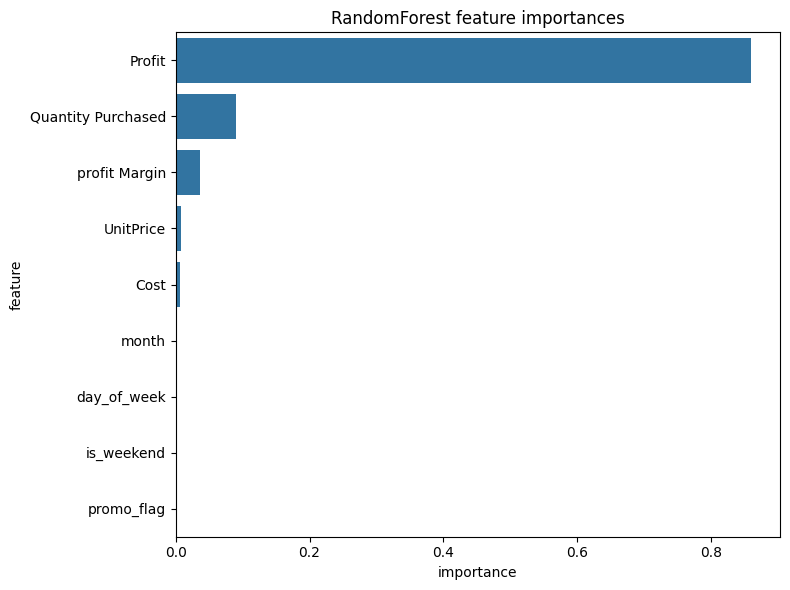

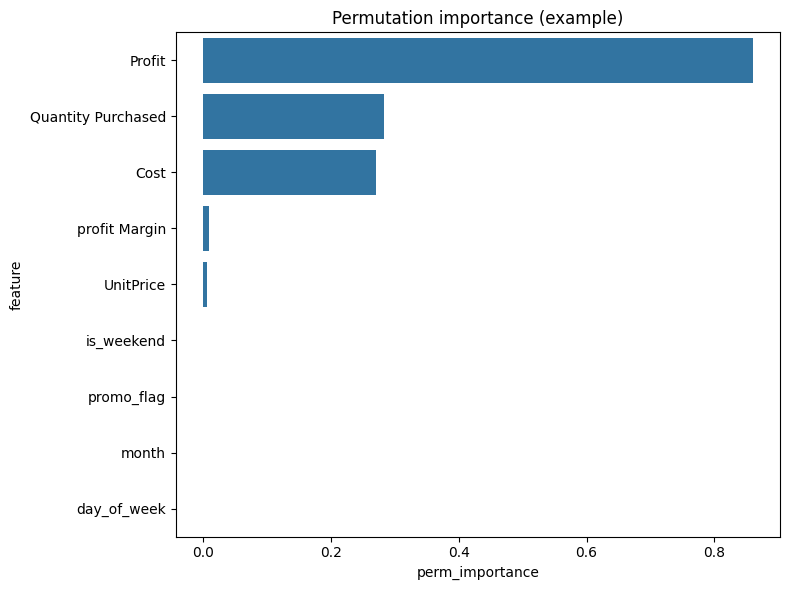

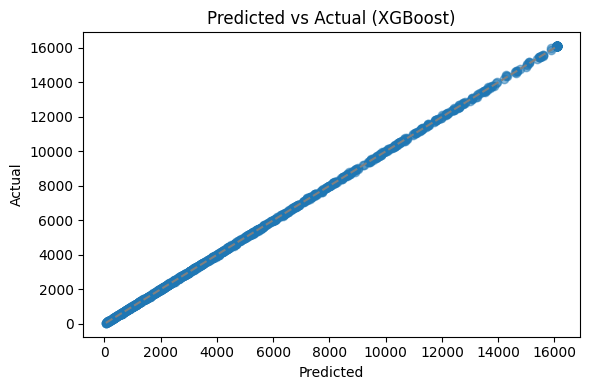

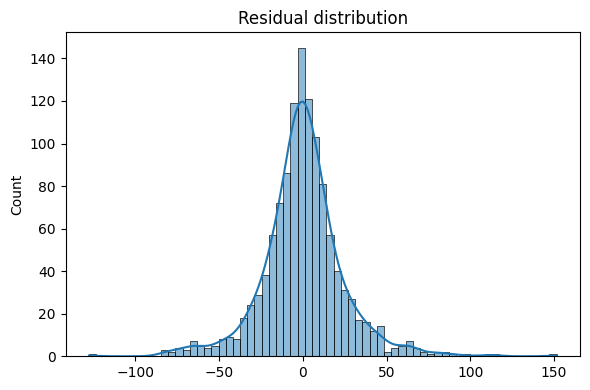

<Figure size 600x400 with 0 Axes>

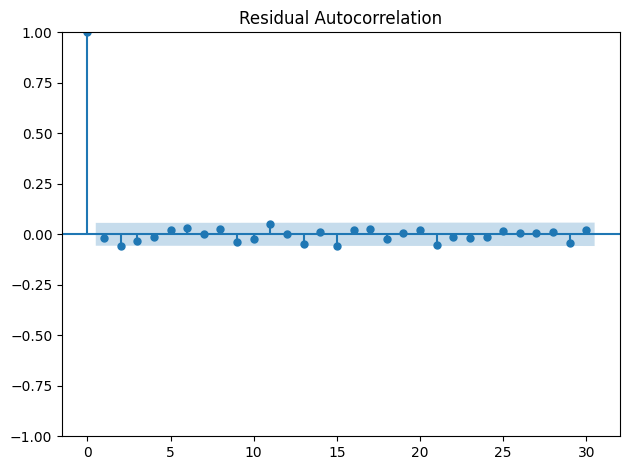

In [10]:
# Feature importance & residual diagnostics
try:
    # Feature importance for tree-based model (if present)
    if 'LightGBM' in models:
        imp = models['LightGBM'].feature_importances_
        imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': imp}).sort_values('importance', ascending=False).head(30)
        plt.figure(figsize=(8,6))
        sns.barplot(x='importance', y='feature', data=imp_df)
        plt.title('LightGBM feature importances ')
        plt.tight_layout()
        plt.show()
    elif 'RandomForest' in models:
        imp = models['RandomForest'].feature_importances_
        imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': imp}).sort_values('importance', ascending=False).head(30)
        plt.figure(figsize=(8,6))
        sns.barplot(x='importance', y='feature', data=imp_df)
        plt.title('RandomForest feature importances')
        plt.tight_layout()
        plt.show()

    # Permutation importance for LR or any fitted model
    pi = permutation_importance(models[list(models.keys())[0]], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    pi_df = pd.DataFrame({'feature': X_test.columns, 'perm_importance': pi.importances_mean}).sort_values('perm_importance', ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x='perm_importance', y='feature', data=pi_df)
    plt.title('Permutation importance (example)')
    plt.tight_layout()
    plt.show()

    # Residuals for the best model in results 
    best = res_df['RMSE'].idxmin()
    y_pred_best = None
    if best in models:
        y_pred_best = models[best].predict(X_test)
    else:
        # fallback to LR
        y_pred_best = y_pred_lr

    resid = y_test - y_pred_best
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred_best, y_test, alpha=0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Predicted vs Actual ({best})')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='grey')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    sns.histplot(resid, kde=True)
    plt.title('Residual distribution')
    plt.tight_layout()
    plt.show()

    # Autocorrelation of residuals
    try:
        from statsmodels.graphics.tsaplots import plot_acf
        plt.figure(figsize=(6,4))
        plot_acf(resid, lags=30)
        plt.title('Residual Autocorrelation')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('statsmodels not installed — skip ACF plot. Error:', e)

except Exception as e:
    print('Run previous modeling cells first. Error:', e)

## Short actionable recommendations

- Use the best-performing tree based model with the top features identified by permutation importance.
- Retrain frequency: weekly if sales patterns change rapidly otherwise bi-weekly/monthly.
- Monitor: track RMSE and bias on a rolling window; trigger retraining if error grows > 10%.
- Deployment: package the preprocessing pipeline (feature engineering, scaler, imputation) + model using joblib; expose as a REST endpoint or scheduled batch job.


In [11]:
# Save the best model to disk
best_model_name = res_df['RMSE'].idxmin()
best_model = models[best_model_name]
joblib.dump(best_model, 'best_sales_model.joblib')
print(f"Saved best model '{best_model_name}' to 'best_sales_model.joblib'")


Saved best model 'XGBoost' to 'best_sales_model.joblib'


In [12]:
#load model
loaded_model = joblib.load('best_sales_model.joblib')
print("Model loaded successfully.")
# show the model type
print("Loaded model type:", type(loaded_model))



Model loaded successfully.
Loaded model type: <class 'xgboost.sklearn.XGBRegressor'>


#  prediction with loaded model

In [13]:
#  prediction with loaded model
# Load the model
loaded_model = joblib.load('best_sales_model.joblib')

# The model was trained on multiple features
expected_features = loaded_model.feature_names_in_
print("Model expects these features:", expected_features)

# Create a dataframe with the same feature names
# Fill all other required features with average or zero values as placeholders
input_data = pd.DataFrame([[5000] + [0]*(len(expected_features)-1)], columns=expected_features)

# Predict profit
predicted_profit = loaded_model.predict(input_data)
print(f" For a Revenue of 5000, the predicted Profit is approximately: {predicted_profit[0]:.2f}")


Model expects these features: ['Quantity Purchased' 'Cost' 'UnitPrice' 'Profit' 'profit Margin' 'month'
 'day_of_week' 'is_weekend' 'promo_flag']
 For a Revenue of 5000, the predicted Profit is approximately: 2646.25
